# Web scraping
---

## What is web scraping?
Following **[Wikipedia](https://en.wikipedia.org/wiki/Web_scraping "Web scraping")**:


Web scraping (web harvesting or web data extraction) is data scraping used for extracting data from websites. Web scraping software may access the World Wide Web directly using the Hypertext Transfer Protocol, or through a web browser. While web scraping can be done manually by a software user, the term typically refers to automated processes implemented using a bot or web crawler. It is a form of copying, in which specific data is gathered and copied from the web, typically into a central local database or spreadsheet, for later retrieval or analysis.


## Web scraping in Python

In Python we can use multiple libraries for web scraping. Among most popular are:

1. **[requests](http://docs.python-requests.org/en/master/)** for Non-GMO HTTP 
2. **[lxml](http://lxml.de/)** for processing XML and HTML
2. **[Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/)**  for quick turnaround projects like screen-scraping
3. **[Selenium](http://selenium-python.readthedocs.io/)** for web browser automation mainly for testing purposes
4. **[Scrapy](https://scrapy.org/)** for creating web crawlers

For static content **requests + Beautiful Soup** is the way to go, but if one wants to get data from modern webpage generated by browser's JavaScript execution **Selenium** is the right tool.

I will use it in the following example.

## Web scraping Zillow offers

Let's import necessary libraries. To use **Selenium** we need to download web driver that we will use to automate our browser, here are few links for most popular ones:

* [Firefox web driver](https://github.com/mozilla/geckodriver/releases)
* [Chrome web driver](https://sites.google.com/a/chromium.org/chromedriver/downloads)

As I downloaded them into notebook directory I will add its path to the `PATH` environment variable to allow Selenium library to find them.

In [1]:
import selenium
from selenium import webdriver
import pandas as pd
import numpy as np
import os
import time
import re

os.getcwd()
os.environ['PATH'] = os.getcwd() + ':' + os.environ['PATH']

Some drivers (e.g. **PhantomJS**, **Chrome** and lately **Firefox** as well) allow us to use a headless browser (a web browser without a graphical user interface). Let's look for an example:

In [2]:
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.chrome.options import Options

chrome_options = Options() # Generate chrome options
chrome_options.add_argument("--headless") # Add headless parameter  

headless_driver = webdriver.Chrome(executable_path=os.path.abspath("chromedriver"), chrome_options=chrome_options) # Run Chrome 
headless_driver.get("http://www.google.com") # Open web page

headless_driver.quit() # Close web browser

In the following example we will use **Firefox** web driver to clearly see what's going on.

First, we need to login into the web app to have all the offers available to us. Also, we will set up a fixed size of the browser window to make our web scraping consistent (web apps usually displays itself differently regarding what's resolution available).

In [3]:
EMAIL = 'l2540055@mvrht.net'
PASSWORD = 'removethisbutleavethis:simplepassword'
LOGIN_PAGE = "https://www.zillow.com/user/Login.htm"
URL = "https://www.zillow.com/homes/for_sale/Castle-Hill-Bronx-New-York-NY/pmf,pf_pt/270812_rid/globalrelevanceex_sort/40.838489,-73.818834,40.799549,-73.880375_rect/14_zm/"

driver = webdriver.Firefox() 
driver.set_window_size(height=800,width=600) # Set window size
driver.get(LOGIN_PAGE) # Open login page

# Find elements by id, clear text fields and put our login credentials then submit the form
email_input = driver.find_element_by_id("email")
email_input.clear()
email_input.send_keys(EMAIL)
password_input = driver.find_element_by_id("password")
password_input.clear()
password_input.send_keys(PASSWORD)
password_input.submit()

I should be logged in by now. Let's open our search results page. A map with results should be visible, let's click the `[ More List ]` button to make a list visible. Then I will click through a paginated list of offers to collect all offer links.

In [4]:
driver.get(URL) # Search results

more_lists_btns = driver.find_elements_by_class_name('more-list')
if len(more_lists_btns) > 0 and more_lists_btns[0].is_displayed():
    more_lists_btns[0].click() # Click [More List] button (if visible) to show list of offers

properties_links = []

while True:
    time.sleep(3) # Wait for a list to be populated by AJAX call
    next_button_elements = driver.find_elements_by_class_name('zsg-pagination-next')  
    results = driver.find_element_by_id('list-results')
    links = results.find_elements_by_class_name('zsg-photo-card-overlay-link')
    for link in links:
        properties_links.append(link.get_attribute('href') + '?fullpage=true') # Collect offer links
    if len(next_button_elements) > 0: # Check if there is a [Next] pagination button
        next_button_elements[0].click()
    else:
        break

I will loop through links and and get some interesting values from every offer.

In [5]:
offers = []

def get_first_element_text(elements):
    if len(elements) > 0:
        return elements[0].text
    else:
        return '--'

for link in properties_links:
    driver.get(link) 

    offer = {}
    offer['zestimate_value'] = driver.find_element_by_class_name('zestimate-value').text # Get an estimated value
    offer['offer_type'] = driver.find_element_by_class_name('status-icon-row').text
    
    if 'SALE' not in offer['offer_type']:
        offer['foreclosure_estimate'] = driver.find_element_by_xpath('//span[@data-target-id="fest-tip-hdp"]/following-sibling::span[1]').text
    else:
        offer['asking_price'] = driver.find_element_by_css_selector('div.main-row.home-summary-row').text            
    
    fact_titles = list(map(lambda x: x.text, driver.find_elements_by_class_name("hdp-fact-ataglance-heading")))
    fact_values = list(map(lambda x: x.text, driver.find_elements_by_class_name("hdp-fact-ataglance-value")))
    
    exterior_xpath = "//h4[.='Exterior Features']/following-sibling::div[1]"
    exterior_value = lambda x: "//span[.='" + x + "']//following-sibling::span[1]"
    
    lot_depth_xpath = exterior_xpath + exterior_value('Lot depth: ')
    lot_width_xpath = exterior_xpath + exterior_value('Lot width: ')
    lot_area_xpath = exterior_xpath + exterior_value('Lot: ')

    offer['exterior_lot'] = get_first_element_text(driver.find_elements_by_xpath(lot_area_xpath))
    offer['exterior_lot_depth'] = get_first_element_text(driver.find_elements_by_xpath(lot_depth_xpath))
    offer['exterior_lot_width'] = get_first_element_text(driver.find_elements_by_xpath(lot_width_xpath))
    
    
    for index, key in enumerate(list(map(lambda x: re.sub(r"[^a-z]", '_', x.lower()), fact_titles))):
        offer[key] = fact_values[index]
    
    offer['address'], offer['city'], info = [s.strip(',') for s in driver.find_element_by_class_name("addr").text.splitlines()]
    info = info.split()
    
    if(len(info) == 6 and info[1] in 'beds' and info[3] in 'baths' and info[5] == 'sqft'):
        offer['beds'], _, offer['baths'], _, offer['sqft'], _ = info
    elif(len(info) == 5 and info[0] == 'Studio' and info[2] in 'baths' and info[4] == 'sqft'):
        offer['beds'] = 1
        _, offer['baths'], _, offer['sqft'], _= info
    else:
        print("\x1b[31m Not processed: " + str(info) + "\x1b[0m")    
    offers.append(offer)   

Ok, done, now what?

___
![Funny relevant gif xD](https://i.giphy.com/media/26DOs997h6fgsCthu/giphy.webp)
___

Let's see what I got! Let's close the browser now. I will use a pandas dataframe to for further data processing and analysis.

In [6]:
driver.quit()
offers_df = pd.DataFrame(offers)
offers_df.head(10)

,address,asking_price,baths,beds,city,cooling,days_on_zillow,exterior_lot,exterior_lot_depth,exterior_lot_width,...,lot,mls__,offer_type,parking,price_sqft,saves,sqft,type,year_built,zestimate_value
0,940 Castle Hill Ave,NaN,--,--,"Bronx, NY 10473",No Data,NaN,"2,613 sqft",--,--,...,"2,613 sqft",NaN,AUCTION,No Data,NaN,NaN,"2,310",Single Family,1910,"$471,517"
1,2123 Quimby Ave,NaN,--,3,"Bronx, NY 10473",Other,NaN,"2,613 sqft",--,--,...,"2,613 sqft",NaN,AUCTION,"Off street, Detached Garage",NaN,NaN,"1,334",Single Family,1915,"$434,368"
2,2259 Cincinnatus Ave,"$449,000",2,3,"Bronx, NY 10473",No Data,20 Days,"2,417 sqft",--,--,...,"2,417 sqft",NaN,FOR SALE,Attached Garage,$260,12,"1,730",Single Family,1935,"$426,172"
3,2252 Story Ave,"$675,000",2,3,"Bronx, NY 10473",No Data,23 Days,"2,927 sqft",103 ft,28 ft,...,NaN,4737049,FOR SALE,Detached Garage,$281,7,"2,400",Multi Family,1925,"$561,580"
4,2125 Quimby Ave,"$350,000",1,2,"Bronx, NY 10473",No Data,230 Days,"2,548 sqft",103 ft,24 ft,...,"2,548 sqft",NaN,FOR SALE,Attached Garage,$262,18,"1,334",Single Family,1915,"$414,824"
5,454 Effingham Ave,"$419,000",1,1,"Bronx, NY 10473",No Data,69 Days,"2,500 sqft",100 ft,25 ft,...,NaN,4729930,FOR SALE,Attached Garage,$256,5,"1,638",Multi Family,1940,"$457,894"
6,501 Olmstead Ave,NaN,4,6,"Bronx, NY 10473",No Data,161 Days,"3,000 sqft",100 ft,30 ft,...,NaN,4734387,FORECLOSURE,Carport,$192,35,"2,345",Multi Family,1987,"$546,832"
7,2217 Homer Ave,"$370,000",2,3,"Bronx, NY 10473",No Data,84 Days,"2,252 sqft",90 ft,25 ft,...,"2,252 sqft",NaN,FOR SALE,Attached Garage,$226,35,"1,638",Single Family,1915,"$401,148"
8,918 Havemeyer Ave,"$750,000",3,8,"Bronx, NY 10473",Other,35 Days,"2,918 sqft",113 ft,25 ft,...,NaN,2960598,FOR SALE,3 spaces,$223,15,"3,360",Multi Family,1945,"$722,696"
9,511 Olmstead Ave,"$575,000",--,2,"Bronx, NY 10473",No Data,64 Days,"2,000 sqft",100 ft,20 ft,...,NaN,69374,FOR SALE,No Data,$247,No Data,"2,325",Multi Family,1987,"$578,884"


In [7]:
offers_df.shape

(83, 23)

In [8]:
offers_df.columns

Index(['address', 'asking_price', 'baths', 'beds', 'city', 'cooling',
       'days_on_zillow', 'exterior_lot', 'exterior_lot_depth',
       'exterior_lot_width', 'foreclosure_estimate', 'heating', 'hoa', 'lot',
       'mls__', 'offer_type', 'parking', 'price_sqft', 'saves', 'sqft', 'type',
       'year_built', 'zestimate_value'],
      dtype='object')

## Data cleaning and analysis

I got the data already but we need to clean it.

In [9]:
offers_df['zestimate_value'] = offers_df['zestimate_value'].replace(r'^$', np.nan, regex=True).str.replace('$','').str.replace(',','').astype(float)
offers_df['asking_price'] = offers_df['asking_price'].str.replace('$','').str.replace(',','').astype(float)
offers_df['sqft'] = offers_df['sqft'].str.replace(',','').astype(int)
offers_df['year_built'] = offers_df['year_built'].replace(r'^No Data$', np.nan, regex=True).astype(float)
offers_df['exterior_lot_depth'] = offers_df['exterior_lot_depth'].replace(r'^--$', np.nan, regex=True).str.replace(' ft','').astype(float)
offers_df['exterior_lot_width'] = offers_df['exterior_lot_width'].replace(r'^--$', np.nan, regex=True).str.replace(' ft','').astype(float)
offers_df['exterior_lot'] = offers_df['exterior_lot'].replace(r'^--$', np.nan, regex=True).str.replace(',','').str.replace(' sqft','').astype(float)
offers_df['baths'] = offers_df['baths'].replace(r'^--$', np.nan, regex=True).astype(float)
offers_df['beds'] = offers_df['beds'].replace(r'^--$', np.nan, regex=True).astype(float)

offers_df['zestimate_price_sqft'] = offers_df['zestimate_value'] / offers_df['sqft']

offers_df.head(10)

,address,asking_price,baths,beds,city,cooling,days_on_zillow,exterior_lot,exterior_lot_depth,exterior_lot_width,...,mls__,offer_type,parking,price_sqft,saves,sqft,type,year_built,zestimate_value,zestimate_price_sqft
0,940 Castle Hill Ave,NaN,NaN,NaN,"Bronx, NY 10473",No Data,NaN,2613.0,NaN,NaN,...,NaN,AUCTION,No Data,NaN,NaN,2310,Single Family,1910.0,471517.0,204.119913
1,2123 Quimby Ave,NaN,NaN,3.0,"Bronx, NY 10473",Other,NaN,2613.0,NaN,NaN,...,NaN,AUCTION,"Off street, Detached Garage",NaN,NaN,1334,Single Family,1915.0,434368.0,325.613193
2,2259 Cincinnatus Ave,449000.0,2.0,3.0,"Bronx, NY 10473",No Data,20 Days,2417.0,NaN,NaN,...,NaN,FOR SALE,Attached Garage,$260,12,1730,Single Family,1935.0,426172.0,246.342197
3,2252 Story Ave,675000.0,2.0,3.0,"Bronx, NY 10473",No Data,23 Days,2927.0,103.0,28.0,...,4737049,FOR SALE,Detached Garage,$281,7,2400,Multi Family,1925.0,561580.0,233.991667
4,2125 Quimby Ave,350000.0,1.0,2.0,"Bronx, NY 10473",No Data,230 Days,2548.0,103.0,24.0,...,NaN,FOR SALE,Attached Garage,$262,18,1334,Single Family,1915.0,414824.0,310.962519
5,454 Effingham Ave,419000.0,1.0,1.0,"Bronx, NY 10473",No Data,69 Days,2500.0,100.0,25.0,...,4729930,FOR SALE,Attached Garage,$256,5,1638,Multi Family,1940.0,457894.0,279.544567
6,501 Olmstead Ave,NaN,4.0,6.0,"Bronx, NY 10473",No Data,161 Days,3000.0,100.0,30.0,...,4734387,FORECLOSURE,Carport,$192,35,2345,Multi Family,1987.0,546832.0,233.190618
7,2217 Homer Ave,370000.0,2.0,3.0,"Bronx, NY 10473",No Data,84 Days,2252.0,90.0,25.0,...,NaN,FOR SALE,Attached Garage,$226,35,1638,Single Family,1915.0,401148.0,244.901099
8,918 Havemeyer Ave,750000.0,3.0,8.0,"Bronx, NY 10473",Other,35 Days,2918.0,113.0,25.0,...,2960598,FOR SALE,3 spaces,$223,15,3360,Multi Family,1945.0,722696.0,215.088095
9,511 Olmstead Ave,575000.0,NaN,2.0,"Bronx, NY 10473",No Data,64 Days,2000.0,100.0,20.0,...,69374,FOR SALE,No Data,$247,No Data,2325,Multi Family,1987.0,578884.0,248.982366


Time for the first graph. What are the types of properies to buy and what are the types of offers?

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


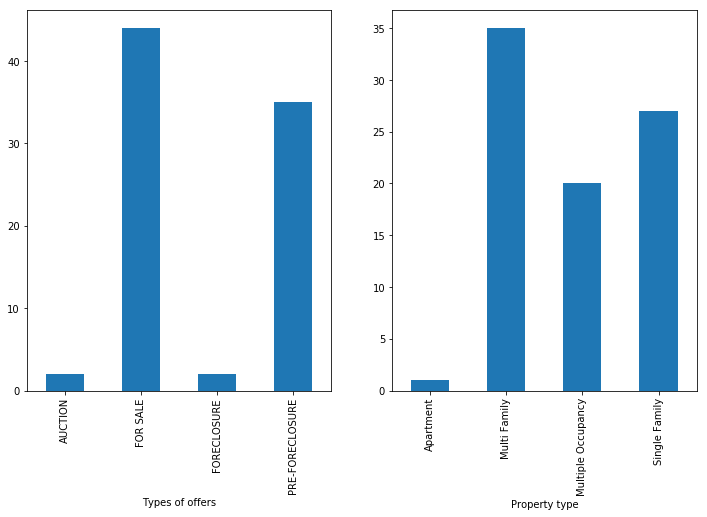

In [10]:
import matplotlib.pyplot as plt

%pylab inline
pylab.rcParams['figure.figsize'] = (12, 7)

fig, axs = plt.subplots(1,2)

offers_df.groupby('offer_type').size().plot(ax=axs[0], kind='bar').set_xlabel('Types of offers')
offers_df.groupby('type').size().plot(ax=axs[1], kind='bar').set_xlabel('Property type')

Let's look at the numeric data.

In [11]:
offers_df.describe()

,asking_price,baths,beds,exterior_lot,exterior_lot_depth,exterior_lot_width,sqft,year_built,zestimate_value,zestimate_price_sqft
count,44.000000,51.000000,56.000000,81.000000,63.000000,63.000000,83.000000,81.000000,82.000000,82.000000
mean,607250.000000,3.068627,4.285714,2539.444444,104.539683,29.000000,2423.120482,1962.592593,554976.939024,242.216716
std,150539.359761,1.905307,2.146577,909.870362,38.319045,23.562545,847.941689,36.544417,114078.254288,39.480544
min,350000.000000,1.000000,1.000000,1742.000000,90.000000,17.000000,1334.000000,1910.000000,366742.000000,71.494887
25%,480250.000000,2.000000,3.000000,1962.000000,93.000000,22.000000,1638.000000,1930.000000,454590.000000,216.317797
50%,659000.000000,3.000000,4.000000,2250.000000,100.000000,25.000000,2345.000000,1960.000000,551501.000000,233.190618
75%,725000.000000,4.000000,5.250000,2860.000000,103.000000,28.000000,3068.000000,2011.000000,662885.000000,273.511743
max,850000.000000,11.000000,9.000000,7033.000000,400.000000,195.000000,6650.000000,2011.000000,791791.000000,325.613193


That data seems to be sensible and we can get an idea how the market looks like.

Let's answer just one more question. Let's look how the estimated sqft price changes with the property size.

Populating the interactive namespace from numpy and matplotlib


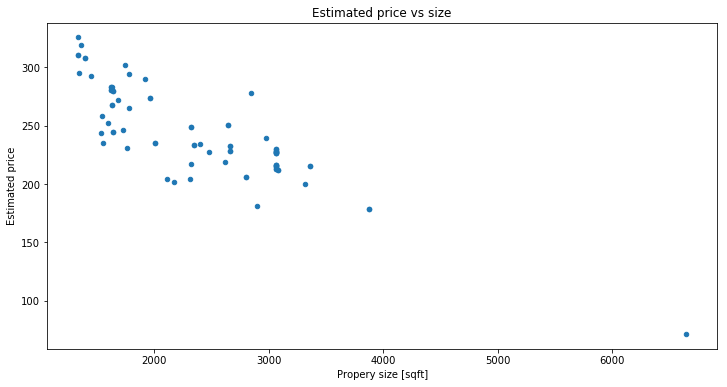

In [12]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)

ax = offers_df.plot.scatter('sqft', 'zestimate_price_sqft', title="Estimated price vs size")
ax.set_xlabel('Propery size [sqft]')
ax.set_ylabel('Estimated price')

Seems like smaller properties are more expensive in terms of price per sqft. I never would have guessed it ;-)

## Summary

Web scraping is a method to get interesting data when there are no better possibilities (e.g. programmatic APIs).

But, there are some caveats:

1. Often webapps terms of use disallow to use this method.
2. Some services introduce traffic/number of operation per interval limits and they block clients if they detect scripted behaviour.
3. When there is no clear structure of the webpage or the webpage changes often it may be challanging to use web scraping.

---
![Funny relevant gif xD](https://i.giphy.com/media/26gYOXsPBh3qv420E/giphy.webp)